In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()#establish connection to sqlite database
Base.prepare(engine, reflect = True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [17]:
start_date = dt.date(2016,9,18)
end_date = dt.date(2016,9,25)

# Exploratory Climate Analysis

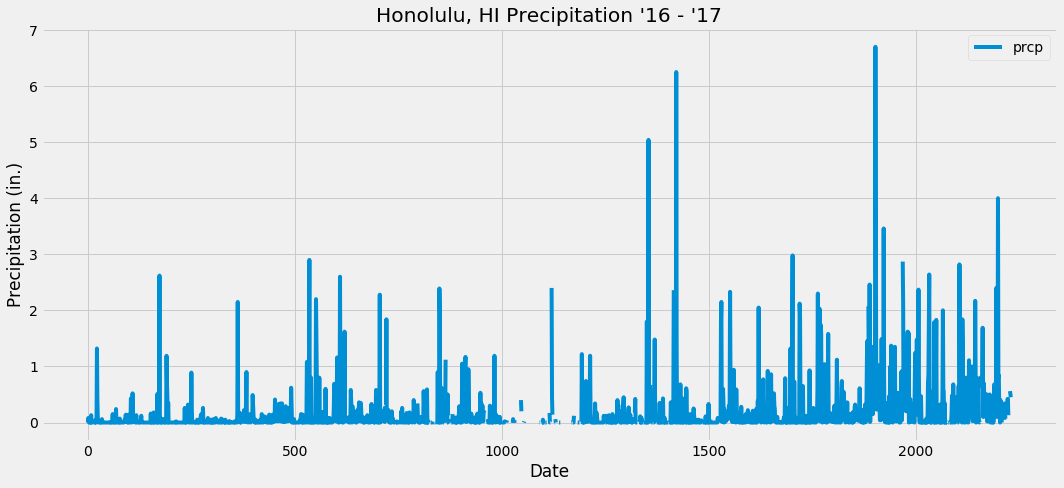

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017,8,23) - dt.timedelta(days = 365)
# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).filter(measurement.date>=prev_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
result_pd = pd.DataFrame(result)
result_pd.set_index(result_pd["date"])
# Sort the dataframe by date
result_pd.head()
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
result_pd.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

#save figure
plt.savefig("Images/precip.png")

#plot figure
plt.tight_layout()
plt.show()


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
result_pd.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station))\
              .group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs), func.avg(measurement.tobs)).\
        filter(measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

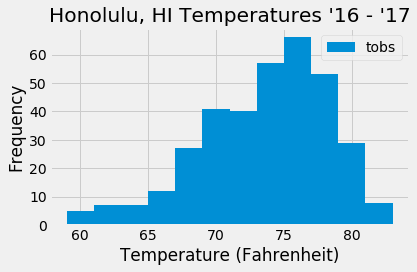

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_new = session.query(measurement.tobs).filter(measurement.date>=prev_year).\
        filter(measurement.station == "USC00519281").all()

df = pd.DataFrame(result_new)
#plot histogram
fig, ax = plt.subplots()
df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, HI Temperatures '16 - '17")

#save figure
plt.savefig("Images/temphist.png")

#plot
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps(start_date, end_date)
#print(trip_temps)
print(f"lowest temperature: {trip_temps[0][0]} F")
print(f"average temperature: {round(trip_temps[0][1],2)} F")
print(f"highest temperature: {trip_temps[0][2]} F")

lowest temperature: 70.0 F
average temperature: 77.67 F
highest temperature: 83.0 F


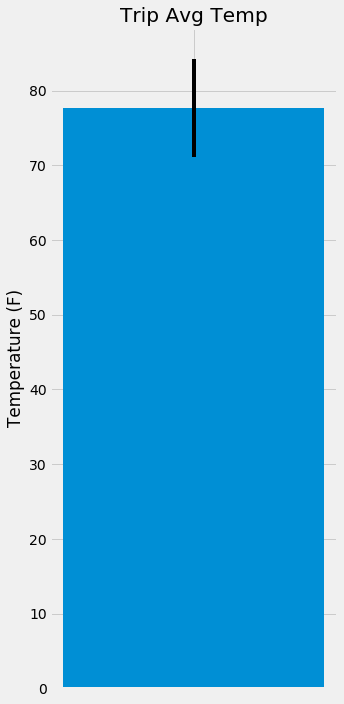

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_pk = trip_temps[0][2]- trip_temps[0][0]
avg_temp = trip_temps[0][1]
#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_pk/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (F)')

#save fig
plt.savefig("Images/tempbar")

#show figure
plt.tight_layout()
plt.show()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_data = session.query(station.station, station.name, station.latitude, station.longitude,
                               station.elevation, measurement.prcp).\
    filter(measurement.station == station.station).\
    filter(func.strftime("%Y-%m-%d", measurement.date) >= dt .date(2016, 8, 23)).group_by(station.station).\
    order_by(measurement.prcp.desc()).all()

station_df = pd.DataFrame(station_data, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Precipitation (in.)'])
station_df

,Station,Name,Latitude,Longitude,Elevation,Precipitation (in.)
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.79
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.70
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.15
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_dates = ["09-18","09-19","09-20","09-21","09-22","09-23","09-24","09-25"]
daily_norms = []
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for trip_date in trip_dates:
    day = {}
    day['date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['min'] = daily_norm[0][0]
    day['avg'] = daily_norm[0][1]
    day['max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'date': '2019-09-18', 'min': 67.0, 'avg': 75.85106382978724, 'max': 84.0},
 {'date': '2019-09-19', 'min': 68.0, 'avg': 76.34693877551021, 'max': 87.0},
 {'date': '2019-09-20', 'min': 69.0, 'avg': 76.14583333333333, 'max': 83.0},
 {'date': '2019-09-21', 'min': 67.0, 'avg': 76.44897959183673, 'max': 84.0},
 {'date': '2019-09-22', 'min': 69.0, 'avg': 76.37254901960785, 'max': 84.0},
 {'date': '2019-09-23', 'min': 67.0, 'avg': 75.82692307692308, 'max': 83.0},
 {'date': '2019-09-24', 'min': 69.0, 'avg': 77.02, 'max': 85.0},
 {'date': '2019-09-25', 'min': 69.0, 'avg': 76.14893617021276, 'max': 83.0}]

In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(daily_norms)
daily_norms_df.set_index('date', inplace = True)
daily_norms_df

,min,avg,max
date,,,
2019-09-18,67.0,75.851064,84.0
2019-09-19,68.0,76.346939,87.0
2019-09-20,69.0,76.145833,83.0
2019-09-21,67.0,76.448980,84.0
2019-09-22,69.0,76.372549,84.0
2019-09-23,67.0,75.826923,83.0
2019-09-24,69.0,77.020000,85.0
2019-09-25,69.0,76.148936,83.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
